In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 26.4M/26.4M [00:17<00:00, 1.52MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.34MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 21.4MB/s]


In [3]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),  # Since input pixels are between 0 and 1
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)


In [6]:
def train_autoencoder(model, train_loader, test_loader, epochs=10):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        model.train()
        for imgs, _ in train_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, imgs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    return model


In [7]:
def evaluate(model, data_loader):
    model.eval()
    total_loss = 0
    criterion = nn.MSELoss(reduction='sum')
    with torch.no_grad():
        for imgs, _ in data_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            total_loss += criterion(outputs, imgs).item()
    return total_loss / len(data_loader.dataset)

def show_reconstructions(model, data_loader, title):
    model.eval()
    imgs, _ = next(iter(data_loader))
    imgs = imgs[:8].to(device)
    with torch.no_grad():
        outputs = model(imgs)
    imgs = imgs.cpu()
    outputs = outputs.cpu()

    fig, axes = plt.subplots(2, 8, figsize=(12, 3))
    for i in range(8):
        axes[0, i].imshow(imgs[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(outputs[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
    plt.suptitle(title)
    plt.show()


In [10]:
def interpolate(model, data_loader):
    model.eval()
    imgs, _ = next(iter(data_loader))
    imgs = imgs[:8].to(device)
    pairs = [(0, 1), (2, 3), (4, 5), (6, 7)]

    fig, axes = plt.subplots(len(pairs), 7, figsize=(14, 8))

    for row, (i, j) in enumerate(pairs):
        z1 = model.encode(imgs[i].unsqueeze(0))
        z2 = model.encode(imgs[j].unsqueeze(0))
        for k, alpha in enumerate(np.linspace(0, 1, 7)):
            z = (1 - alpha) * z1 + alpha * z2
            out = model.decode(z)
            # Detach the tensor 'out' before converting to NumPy array
            axes[row, k].imshow(out[0].cpu().detach().squeeze(), cmap='gray')
            axes[row, k].axis('off')
    plt.suptitle("Latent Space Interpolation")
    plt.show()

Epoch [1/10], Loss: 0.0193
Epoch [2/10], Loss: 0.0183
Epoch [3/10], Loss: 0.0160
Epoch [4/10], Loss: 0.0159
Epoch [5/10], Loss: 0.0151
Epoch [6/10], Loss: 0.0148
Epoch [7/10], Loss: 0.0130
Epoch [8/10], Loss: 0.0153
Epoch [9/10], Loss: 0.0131
Epoch [10/10], Loss: 0.0140
Latent 16 - Train MSE: 10.2033, Test MSE: 10.3326


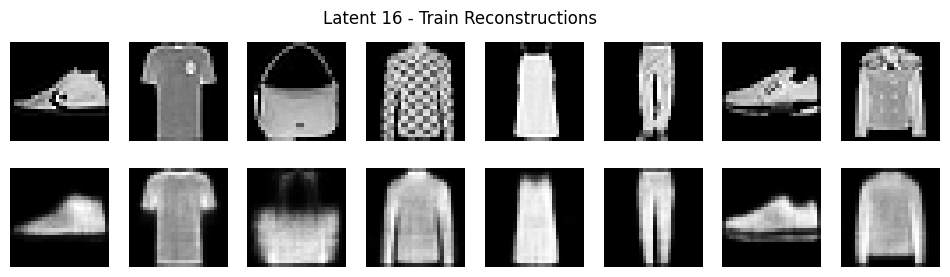

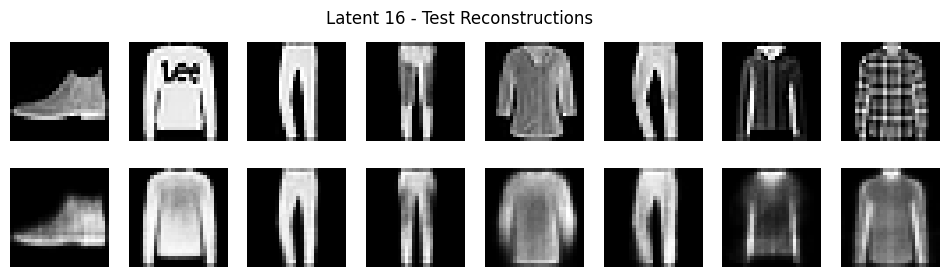

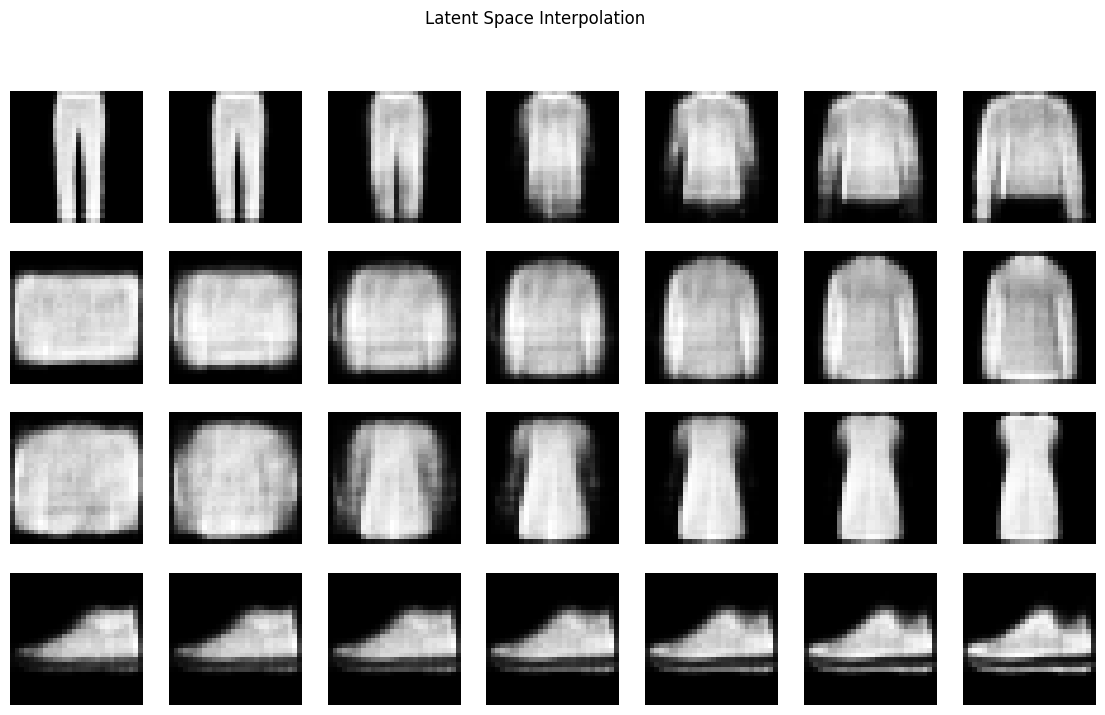

In [11]:
# Train AE with latent_dim = 16
model_16 = Autoencoder(latent_dim=16).to(device)
model_16 = train_autoencoder(model_16, train_loader, test_loader, epochs=10)
train_loss_16 = evaluate(model_16, train_loader)
test_loss_16 = evaluate(model_16, test_loader)
print(f"Latent 16 - Train MSE: {train_loss_16:.4f}, Test MSE: {test_loss_16:.4f}")
show_reconstructions(model_16, train_loader, "Latent 16 - Train Reconstructions")
show_reconstructions(model_16, test_loader, "Latent 16 - Test Reconstructions")
interpolate(model_16, train_loader)

Epoch [1/10], Loss: 0.0216
Epoch [2/10], Loss: 0.0164
Epoch [3/10], Loss: 0.0139
Epoch [4/10], Loss: 0.0144
Epoch [5/10], Loss: 0.0126
Epoch [6/10], Loss: 0.0110
Epoch [7/10], Loss: 0.0134
Epoch [8/10], Loss: 0.0112
Epoch [9/10], Loss: 0.0111
Epoch [10/10], Loss: 0.0102
Latent 48 - Train MSE: 8.2473, Test MSE: 8.3626


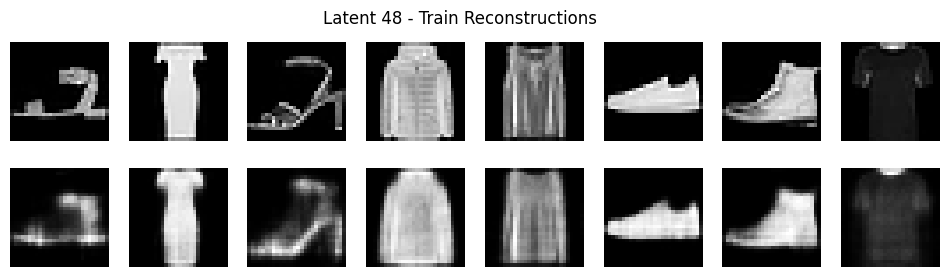

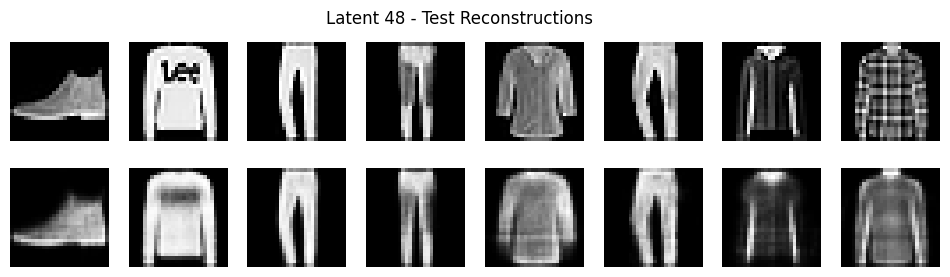

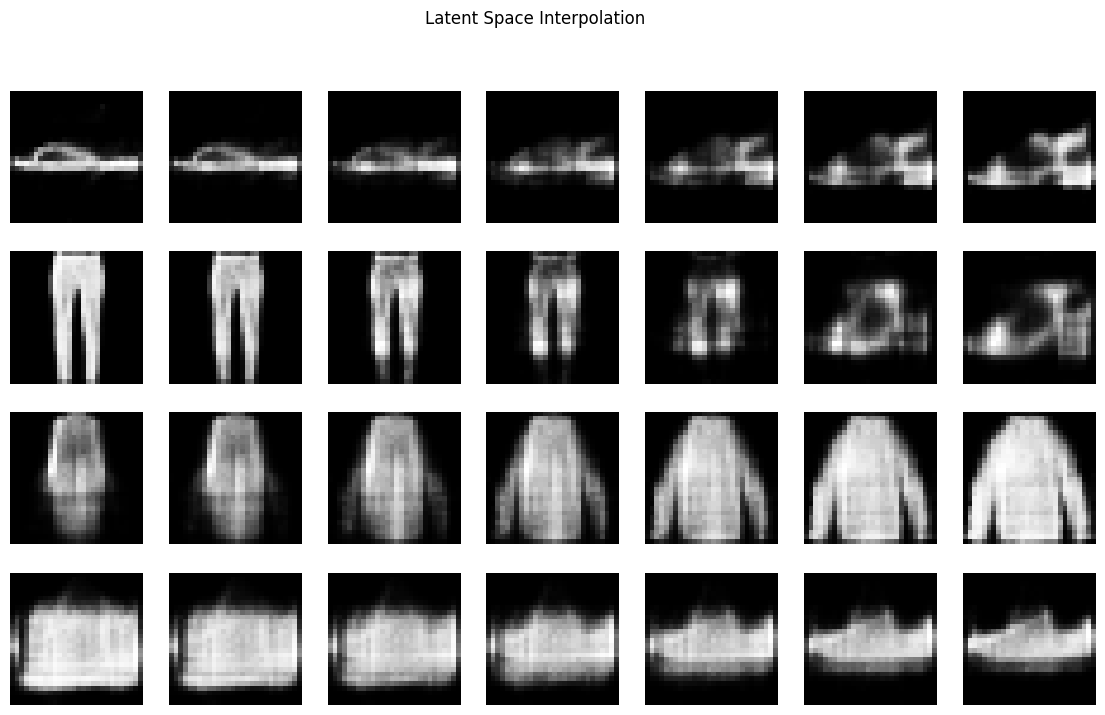

In [12]:
# Train AE with latent_dim = 48
model_48 = Autoencoder(latent_dim=48).to(device)
model_48 = train_autoencoder(model_48, train_loader, test_loader, epochs=10)
train_loss_48 = evaluate(model_48, train_loader)
test_loss_48 = evaluate(model_48, test_loader)
print(f"Latent 48 - Train MSE: {train_loss_48:.4f}, Test MSE: {test_loss_48:.4f}")
show_reconstructions(model_48, train_loader, "Latent 48 - Train Reconstructions")
show_reconstructions(model_48, test_loader, "Latent 48 - Test Reconstructions")
interpolate(model_48, train_loader)

In [13]:
class VAE(nn.Module):
    def __init__(self, latent_dim=12):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 256)
        self.fc3 = nn.Linear(256, 28*28)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        x = x.view(-1, 28*28)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [14]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [15]:
def train_vae(model, dataloader, epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for x, _ in dataloader:
            x = x.to(device)
            recon, mu, logvar = model(x)
            loss = loss_function(recon, x, mu, logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(dataloader.dataset):.4f}")


In [16]:
def generate_samples(model, n_samples=50):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, 12).to(device)
        samples = model.decode(z).view(-1, 1, 28, 28).cpu()
    return samples

def show_samples(samples, title="Generated Samples"):
    grid_size = int(np.sqrt(len(samples)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(6, 6))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = i * grid_size + j
            axes[i, j].imshow(samples[idx][0], cmap='gray')
            axes[i, j].axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


In [17]:
def tweak_latent(model, dim=0, values=[-3, -2, -1, 0, 1, 2, 3]):
    model.eval()
    with torch.no_grad():
        fig, axes = plt.subplots(1, len(values), figsize=(14, 2))
        for i, v in enumerate(values):
            z = torch.zeros(1, 12).to(device)
            z[0, dim] = v
            out = model.decode(z).view(28, 28).cpu()
            axes[i].imshow(out, cmap='gray')
            axes[i].axis('off')
        plt.suptitle(f"Tweaking latent dimension {dim}")
        plt.show()


Epoch [1/40], Loss: 288.7583
Epoch [2/40], Loss: 255.8283
Epoch [3/40], Loss: 250.8156
Epoch [4/40], Loss: 248.3869
Epoch [5/40], Loss: 246.8572
Epoch [6/40], Loss: 245.8352
Epoch [7/40], Loss: 245.0716
Epoch [8/40], Loss: 244.4235
Epoch [9/40], Loss: 244.0334
Epoch [10/40], Loss: 243.5788
Epoch [11/40], Loss: 243.2697
Epoch [12/40], Loss: 242.9755
Epoch [13/40], Loss: 242.6402
Epoch [14/40], Loss: 242.4421
Epoch [15/40], Loss: 242.2466
Epoch [16/40], Loss: 242.0441
Epoch [17/40], Loss: 241.8757
Epoch [18/40], Loss: 241.6861
Epoch [19/40], Loss: 241.5745
Epoch [20/40], Loss: 241.4258
Epoch [21/40], Loss: 241.2893
Epoch [22/40], Loss: 241.2011
Epoch [23/40], Loss: 241.0627
Epoch [24/40], Loss: 241.0076
Epoch [25/40], Loss: 240.8455
Epoch [26/40], Loss: 240.7954
Epoch [27/40], Loss: 240.7210
Epoch [28/40], Loss: 240.6793
Epoch [29/40], Loss: 240.5706
Epoch [30/40], Loss: 240.5165
Epoch [31/40], Loss: 240.4230
Epoch [32/40], Loss: 240.3419
Epoch [33/40], Loss: 240.3061
Epoch [34/40], Loss

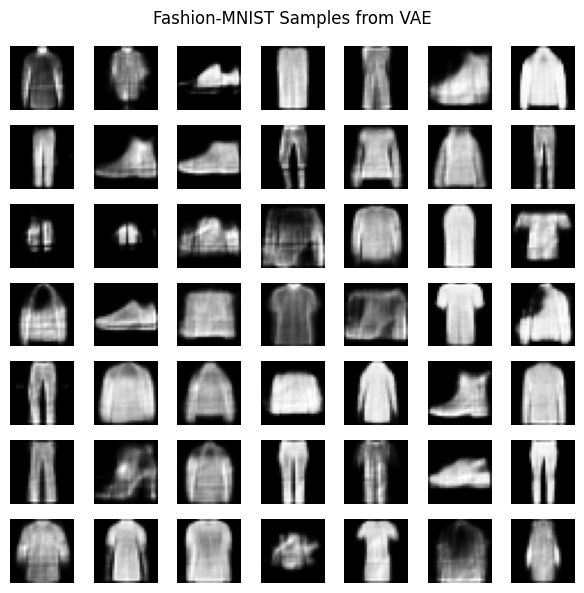

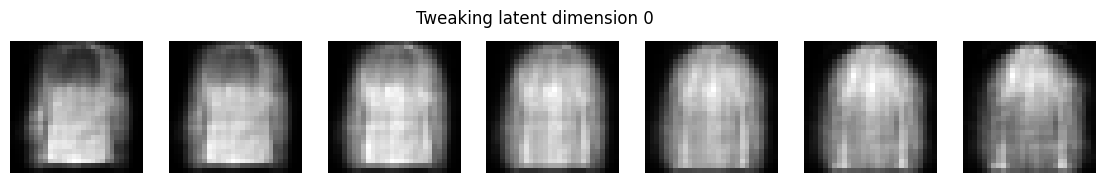

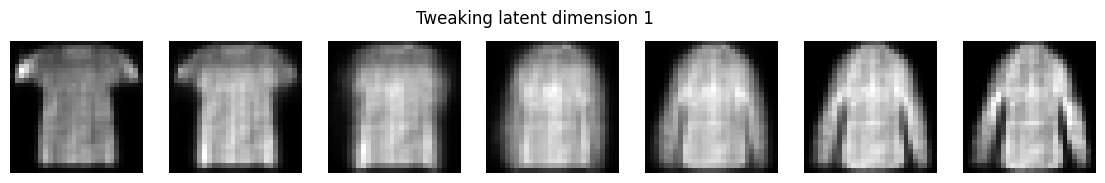

In [19]:
vae = VAE(latent_dim=12).to(device)
train_vae(vae, train_loader, epochs=40)

samples = generate_samples(vae, 49)
show_samples(samples, "Fashion-MNIST Samples from VAE")
tweak_latent(vae, dim=0)
tweak_latent(vae, dim=1)